# Notebook to Implement Model Training - LGBM

---

### Atualização sobre o status do projeto

### 1) Setup

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy import stats
from scipy.stats import wilcoxon

from sklearn.metrics import balanced_accuracy_score, make_scorer, confusion_matrix, classification_report
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest

import optuna
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE,KMeansSMOTE, ADASYN 

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

C:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
SEED = 42

In [6]:
TRAIN_CLINICAL_FILENAME = "train_set.csv"
TEST_CLINICAL_FILENAME = "test_set.csv"

---

### 2) Read and Preprocess Data

In [7]:
train = pd.read_csv(TRAIN_CLINICAL_FILENAME, sep=",")
train = train.iloc[: , 1:]

In [8]:
train.shape

(132, 636)

In [9]:
train.head()

,Freq.1198.05707939985,Freq.1204.07148226988,Freq.1211.25531677913,Freq.1217.79534957812,Freq.1223.24180676615,Freq.1234.42874922858,Freq.1239.04873179697,Freq.1243.98934968702,Freq.1249.10239635402,Freq.1254.7097579948,...,Freq.8943.76551923189,Freq.9058.85825530971,Freq.9098.58510797401,Freq.9437.74469644083,Freq.9593.90405666006,Freq.9799.842201746,Freq.10432.4853106264,Freq.11006.9514551194,Freq.11161.31855876,Group
0,0.000319,0.000416,0.000077,4.034140e-05,0.000089,0.000282,0.000004,0.000130,0.000288,0.000000e+00,...,0.000017,0.000005,0.000020,0.000029,0.000037,0.000024,0.000016,0.000030,0.000030,MILD
1,0.000000,0.000000,0.000021,1.064014e-03,0.000113,0.001591,0.016310,0.002330,0.000476,6.074661e-04,...,0.000040,0.000010,0.000001,0.000005,0.000002,0.000052,0.000003,0.000155,0.000001,MILD
2,0.000199,0.000006,0.000013,5.089552e-08,0.000087,0.000543,0.000231,0.000068,0.000018,1.286428e-04,...,0.000009,0.000044,0.000012,0.000067,0.000207,0.000020,0.000027,0.000100,0.000100,MILD
3,0.000196,0.000244,0.000069,4.874671e-05,0.000125,0.000353,0.000029,0.000125,0.000120,4.988436e-07,...,0.000072,0.000051,0.000013,0.000061,0.000040,0.000008,0.000003,0.000055,0.000029,MILD
4,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000027,0.000031,0.000014,0.000017,0.000028,0.000009,0.000012,0.000026,0.000017,MILD


In [10]:
##### Preprocessing

train_mod = train.copy()
# Imputation using mean method
#train_mod = train_mod.replace(0,np.nan)
#train_mod_imp = train_mod.transform(lambda x: x.fillna(x.mean()))

In [11]:
train_mod.shape

(132, 636)

In [12]:
train_mod.head()

,Freq.1198.05707939985,Freq.1204.07148226988,Freq.1211.25531677913,Freq.1217.79534957812,Freq.1223.24180676615,Freq.1234.42874922858,Freq.1239.04873179697,Freq.1243.98934968702,Freq.1249.10239635402,Freq.1254.7097579948,...,Freq.8943.76551923189,Freq.9058.85825530971,Freq.9098.58510797401,Freq.9437.74469644083,Freq.9593.90405666006,Freq.9799.842201746,Freq.10432.4853106264,Freq.11006.9514551194,Freq.11161.31855876,Group
0,0.000319,0.000416,0.000077,4.034140e-05,0.000089,0.000282,0.000004,0.000130,0.000288,0.000000e+00,...,0.000017,0.000005,0.000020,0.000029,0.000037,0.000024,0.000016,0.000030,0.000030,MILD
1,0.000000,0.000000,0.000021,1.064014e-03,0.000113,0.001591,0.016310,0.002330,0.000476,6.074661e-04,...,0.000040,0.000010,0.000001,0.000005,0.000002,0.000052,0.000003,0.000155,0.000001,MILD
2,0.000199,0.000006,0.000013,5.089552e-08,0.000087,0.000543,0.000231,0.000068,0.000018,1.286428e-04,...,0.000009,0.000044,0.000012,0.000067,0.000207,0.000020,0.000027,0.000100,0.000100,MILD
3,0.000196,0.000244,0.000069,4.874671e-05,0.000125,0.000353,0.000029,0.000125,0.000120,4.988436e-07,...,0.000072,0.000051,0.000013,0.000061,0.000040,0.000008,0.000003,0.000055,0.000029,MILD
4,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000027,0.000031,0.000014,0.000017,0.000028,0.000009,0.000012,0.000026,0.000017,MILD


In [13]:
test = pd.read_csv(TEST_CLINICAL_FILENAME, sep=",")
test = test.iloc[: , 1:]
test_mod = test.copy()
test_mod.head()

,Freq.1198.05707939985,Freq.1204.07148226988,Freq.1211.25531677913,Freq.1217.79534957812,Freq.1223.24180676615,Freq.1234.42874922858,Freq.1239.04873179697,Freq.1243.98934968702,Freq.1249.10239635402,Freq.1254.7097579948,...,Freq.8943.76551923189,Freq.9058.85825530971,Freq.9098.58510797401,Freq.9437.74469644083,Freq.9593.90405666006,Freq.9799.842201746,Freq.10432.4853106264,Freq.11006.9514551194,Freq.11161.31855876,Group
0,0.000226,0.000341,0.000194,0.000136,0.000341,0.000111,0.000049,0.000696,0.000122,0.000120,...,0.000071,0.000025,0.000027,7.788256e-07,0.000016,0.000008,1.721324e-05,0.000021,0.000009,MILD
1,0.000001,0.000056,0.000037,0.000028,0.000019,0.000081,0.000047,0.000235,0.000203,0.000245,...,0.000003,0.000008,0.000012,1.775512e-05,0.000234,0.000042,4.124686e-05,0.000015,0.000066,MILD
2,0.000228,0.000264,0.000006,0.000133,0.000145,0.000032,0.000784,0.000206,0.000144,0.000113,...,0.000008,0.000047,0.000026,1.507294e-05,0.000085,0.000024,5.582014e-05,0.000042,0.000055,MILD
3,0.003657,0.001790,0.000223,0.000156,0.001859,0.000178,0.000610,0.001428,0.000555,0.000002,...,0.000011,0.000004,0.000002,2.146685e-06,0.000004,0.000006,1.355618e-07,0.000003,0.000003,MILD
4,0.000003,0.000369,0.000084,0.000026,0.000079,0.000000,0.000520,0.000455,0.000249,0.000111,...,0.000002,0.000021,0.000005,2.076648e-05,0.000050,0.000003,6.206094e-05,0.000022,0.000026,MILD


In [14]:
X_test, y_test = test_mod.drop("Group", axis=1), test_mod["Group"]

---

### 3) Baseline Model Training and CV

In [15]:
# Define Classifier (or pipeline)
clf = lgb.LGBMClassifier(random_state=SEED)

In [16]:
# Get Features and Target
X, y = train_mod.drop("Group", axis=1), train_mod["Group"]

In [17]:
# Defining RepeatedKFold Cross Validator
rkf = RepeatedKFold(n_splits=5, n_repeats=20, random_state=SEED)

In [18]:
# Define metric scorer
metric_scorer = make_scorer(balanced_accuracy_score)
metric_scorer

make_scorer(balanced_accuracy_score)

In [19]:
# Cross validate model
scores = cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1)

In [20]:
# Score from each CV Iteration
scores

array([0.82236842, 0.75      , 0.86842105, 0.73076923, 0.85119048,
       0.875     , 0.875     , 0.76190476, 0.7375    , 0.88888889,
       0.82954545, 0.79117647, 0.72556391, 0.72916667, 0.85625   ,
       0.83333333, 0.85      , 0.85714286, 0.80065359, 0.69281046,
       0.63333333, 0.88486842, 0.70606061, 0.8       , 0.81875   ,
       0.80833333, 0.88736264, 0.59722222, 0.69281046, 0.85947712,
       0.69444444, 0.83235294, 0.77819549, 0.78125   , 0.69281046,
       0.69602273, 0.78618421, 0.72619048, 0.56666667, 0.76785714,
       0.75      , 0.75      , 0.83030303, 0.83030303, 0.88194444,
       0.78021978, 0.90909091, 0.80392157, 0.7875    , 0.82330827,
       0.8       , 0.64166667, 0.7875    , 0.74509804, 0.81875   ,
       0.83238636, 0.75      , 0.70138889, 0.80357143, 0.75      ,
       0.72058824, 0.69444444, 0.80952381, 0.84722222, 0.64285714,
       0.68333333, 0.8       , 0.88194444, 0.72916667, 0.83030303,
       0.78693182, 0.79117647, 0.6875    , 0.91176471, 0.76363

In [21]:
# Mean Metric Value
np.mean(scores)

0.7818376105748396

# Feature reduction

In [22]:
train_mod_stats = train_mod.drop('Group', axis = 1)

#### Testing feature reduction using just statistics

In [23]:
df = train_mod.copy()
peaks_list = []
pval_list = []
df2 = pd.melt(df, id_vars = ["Group"])
mild = df.where(df.Group == "MILD").dropna()
sev = df.where(df.Group == "SEVERE").dropna()
for i in range(1,(len(df.columns)-1)):
    s, p1 = stats.mannwhitneyu(mild.iloc[:,i], sev.iloc[:,i], alternative = 'two-sided')
    if p1 <= 0.05:
        pval_list.append(p1)
        peaks_list.append(df.columns[i])
peaks_list.append("Group")

In [24]:
df_filtered = df.drop(columns=[col for col in df if col not in peaks_list])
df_test_filtered = test.drop(columns=[col for col in test if col not in peaks_list])

In [25]:
df_test_filtered.shape

(64, 150)

---

In [26]:
# Get Features and Target
X, y = df_filtered.drop("Group", axis=1), df_filtered["Group"]
X_test, y_test = df_test_filtered.drop("Group", axis=1), df_test_filtered["Group"]
# Cross validate model
scores = cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1)
# Score from each CV Iteration
scores

array([0.79605263, 0.88888889, 0.82330827, 0.76923077, 0.96428571,
       0.88333333, 0.75986842, 0.80357143, 0.7375    , 0.88888889,
       0.79829545, 0.82058824, 0.7518797 , 0.75694444, 0.86875   ,
       0.88888889, 0.9       , 0.81547619, 0.82679739, 0.71568627,
       0.70833333, 0.88486842, 0.71818182, 0.8       , 0.81875   ,
       0.73333333, 0.88736264, 0.60416667, 0.71895425, 0.83006536,
       0.80555556, 0.83235294, 0.80451128, 0.875     , 0.72222222,
       0.78693182, 0.8125    , 0.79761905, 0.625     , 0.85119048,
       0.75      , 0.8       , 0.73939394, 0.86363636, 0.88194444,
       0.8543956 , 0.87784091, 0.83006536, 0.86875   , 0.82330827,
       0.9       , 0.725     , 0.80625   , 0.71568627, 0.8875    ,
       0.95454545, 0.8       , 0.70138889, 0.88095238, 0.7       ,
       0.72058824, 0.75      , 0.80952381, 0.78472222, 0.68452381,
       0.725     , 0.76666667, 0.81944444, 0.79166667, 0.84242424,
       0.86363636, 0.79117647, 0.75625   , 0.94117647, 0.76363

In [27]:
# Mean Metric Value
np.mean(scores)

0.8039530045547848

* A acurácia balanceada foi levemente melhor com a redução de features

### 4) Testing hyperparameter optimization methods

##### 4.1) Hyper Parameter Optimization with Optuna

In [28]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": 1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model with param trial
    clf = lgb.LGBMClassifier(random_state=SEED, **param)
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [29]:
study = optuna.create_study(direction="maximize")

[I 2022-07-20 01:24:16,035] A new study created in memory with name: no-name-6a9f756b-8650-4a0d-8f39-1d72d9f320b7


In [30]:
study.optimize(objective, n_trials=50)

[I 2022-07-20 01:24:26,699] Trial 0 finished with value: 0.6379481800449293 and parameters: {'lambda_l1': 0.0036797231389138958, 'lambda_l2': 0.03130225977497874, 'num_leaves': 85, 'feature_fraction': 0.4075848431203048, 'bagging_fraction': 0.4678727546839163, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 451}. Best is trial 0 with value: 0.6379481800449293.
[I 2022-07-20 01:24:31,179] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 1.3219952018376395, 'lambda_l2': 0.0018237518797247056, 'num_leaves': 173, 'feature_fraction': 0.6129700315629567, 'bagging_fraction': 0.49739035267514153, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 636}. Best is trial 0 with value: 0.6379481800449293.
[I 2022-07-20 01:24:34,356] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 0.6352958932590762, 'lambda_l2': 0.017717918365909097, 'num_leaves': 44, 'feature_fraction': 0.8478246735788907, 'bagging_fraction': 0.766556076261897, 'bagging_freq': 2, 'min_chi

[I 2022-07-20 01:25:55,466] Trial 22 finished with value: 0.833168533779602 and parameters: {'lambda_l1': 0.0005839958830503054, 'lambda_l2': 1.4969594680326138e-05, 'num_leaves': 220, 'feature_fraction': 0.9020425357291861, 'bagging_fraction': 0.4997363374295409, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 847}. Best is trial 13 with value: 0.8778453713469194.
[I 2022-07-20 01:26:00,933] Trial 23 finished with value: 0.8803659137989632 and parameters: {'lambda_l1': 0.0004069926220181234, 'lambda_l2': 1.2381078904627222e-07, 'num_leaves': 134, 'feature_fraction': 0.8096173466023409, 'bagging_fraction': 0.4048882740474993, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 978}. Best is trial 23 with value: 0.8803659137989632.
[I 2022-07-20 01:26:06,980] Trial 24 finished with value: 0.8699650345569464 and parameters: {'lambda_l1': 1.9149381595709434e-05, 'lambda_l2': 1.0097625782643582e-07, 'num_leaves': 131, 'feature_fraction': 0.8074276639049041, 'bagging_fraction':

[I 2022-07-20 01:27:40,729] Trial 44 finished with value: 0.5 and parameters: {'lambda_l1': 6.839810222188678e-06, 'lambda_l2': 1.5397139310246655e-08, 'num_leaves': 117, 'feature_fraction': 0.827760009489995, 'bagging_fraction': 0.5275806845672749, 'bagging_freq': 5, 'min_child_samples': 36, 'max_depth': 725}. Best is trial 23 with value: 0.8803659137989632.
[I 2022-07-20 01:27:44,219] Trial 45 finished with value: 0.8726604268839177 and parameters: {'lambda_l1': 0.0003961590062894261, 'lambda_l2': 0.07178661481644083, 'num_leaves': 143, 'feature_fraction': 0.6696883658848364, 'bagging_fraction': 0.660115418046292, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 602}. Best is trial 23 with value: 0.8803659137989632.
[I 2022-07-20 01:27:53,119] Trial 46 finished with value: 0.8519747372725314 and parameters: {'lambda_l1': 0.0029153962498022438, 'lambda_l2': 0.25504967315059535, 'num_leaves': 148, 'feature_fraction': 0.6898768911253959, 'bagging_fraction': 0.7015417618536579, '

In [31]:
# Get best trial based on metric score
trial = study.best_trial

In [32]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    lambda_l1: 0.0004069926220181234
    lambda_l2: 1.2381078904627222e-07
    num_leaves: 134
    feature_fraction: 0.8096173466023409
    bagging_fraction: 0.4048882740474993
    bagging_freq: 5
    min_child_samples: 23
    max_depth: 978


In [33]:
# Best Score from HP Opt
trial.values[0]

0.8803659137989632

- Aumento de performance considerável em relação ao valor baseline para um LGBM

##### 4.2) PCA Dimension Reduction + Hyper Parameter Optimization with Optuna

In [34]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # PCA Parameter Grid
    pca_param = {
        "n_components": trial.suggest_int("n_components", 5, 100)
    }
    # Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": 1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("pca", PCA(**pca_param)),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [35]:
study = optuna.create_study(direction="maximize")

[I 2022-07-20 01:33:59,868] A new study created in memory with name: no-name-ee89e02e-b9b8-4102-b694-cc23ad5425ff


In [36]:
study.optimize(objective, n_trials=50)

[I 2022-07-20 01:34:05,937] Trial 0 finished with value: 0.6710293619564132 and parameters: {'n_components': 34, 'lambda_l1': 1.1703878880570091e-07, 'lambda_l2': 0.0003738574896336515, 'num_leaves': 85, 'feature_fraction': 0.7002410543685882, 'bagging_fraction': 0.6791814512427448, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 488}. Best is trial 0 with value: 0.6710293619564132.
[I 2022-07-20 01:34:08,692] Trial 1 finished with value: 0.5 and parameters: {'n_components': 16, 'lambda_l1': 4.141407679902364e-08, 'lambda_l2': 1.0348908257906732e-06, 'num_leaves': 78, 'feature_fraction': 0.4529568736237706, 'bagging_fraction': 0.5717148844475046, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 835}. Best is trial 0 with value: 0.6710293619564132.
[I 2022-07-20 01:34:10,397] Trial 2 finished with value: 0.5 and parameters: {'n_components': 79, 'lambda_l1': 0.6873214791738491, 'lambda_l2': 0.0015262190464139583, 'num_leaves': 6, 'feature_fraction': 0.52017629729427, 'ba

[I 2022-07-20 01:35:32,367] Trial 21 finished with value: 0.7209733279276623 and parameters: {'n_components': 53, 'lambda_l1': 2.602881494153041e-05, 'lambda_l2': 0.00012979084274164734, 'num_leaves': 125, 'feature_fraction': 0.895996440431286, 'bagging_fraction': 0.7788989636075041, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 840}. Best is trial 5 with value: 0.7284628855406718.
[I 2022-07-20 01:35:39,887] Trial 22 finished with value: 0.7259933873101444 and parameters: {'n_components': 49, 'lambda_l1': 3.481621207223147e-05, 'lambda_l2': 0.004008711223082693, 'num_leaves': 139, 'feature_fraction': 0.8914728076657998, 'bagging_fraction': 0.8772411455313759, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 999}. Best is trial 5 with value: 0.7284628855406718.
[I 2022-07-20 01:35:46,777] Trial 23 finished with value: 0.7244096381559616 and parameters: {'n_components': 47, 'lambda_l1': 3.6740213831478658e-06, 'lambda_l2': 0.0026304919258495455, 'num_leaves': 48, 'feat

[I 2022-07-20 01:37:00,557] Trial 42 finished with value: 0.740715942940788 and parameters: {'n_components': 79, 'lambda_l1': 1.7639060983491126e-07, 'lambda_l2': 9.585251118449484e-08, 'num_leaves': 237, 'feature_fraction': 0.9009479553927022, 'bagging_fraction': 0.6507548668229022, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 639}. Best is trial 42 with value: 0.740715942940788.
[I 2022-07-20 01:37:04,887] Trial 43 finished with value: 0.7287151860437464 and parameters: {'n_components': 80, 'lambda_l1': 1.037568254840699e-08, 'lambda_l2': 5.326242975913729e-07, 'num_leaves': 237, 'feature_fraction': 0.8445262501889179, 'bagging_fraction': 0.6423448377356257, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 637}. Best is trial 42 with value: 0.740715942940788.
[I 2022-07-20 01:37:10,317] Trial 44 finished with value: 0.7302418943285817 and parameters: {'n_components': 70, 'lambda_l1': 1.283313290679408e-06, 'lambda_l2': 3.964026812264752e-08, 'num_leaves': 209, 'fe

In [37]:
# Get best trial based on metric score
trial = study.best_trial

In [38]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    n_components: 79
    lambda_l1: 1.7639060983491126e-07
    lambda_l2: 9.585251118449484e-08
    num_leaves: 237
    feature_fraction: 0.9009479553927022
    bagging_fraction: 0.6507548668229022
    bagging_freq: 1
    min_child_samples: 11
    max_depth: 639


In [39]:
# Best Score from HP Opt
trial.values[0]

0.740715942940788

- Utilizar redução de dimensionalidade via PCA piorou bastante a performance do modelo

##### 4.3) Features Scaler + Hyper Parameter Optimization with Optuna

In [40]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [41]:
study = optuna.create_study(direction="maximize")

[I 2022-07-20 01:42:46,958] A new study created in memory with name: no-name-528ff941-c942-46d3-9080-ac9856f96a8d


In [42]:
study.optimize(objective, n_trials=50)

[I 2022-07-20 01:42:57,068] Trial 0 finished with value: 0.5 and parameters: {'scalers': 'minmax', 'lambda_l1': 3.45681505416755e-05, 'lambda_l2': 3.218966402128704e-05, 'num_leaves': 215, 'feature_fraction': 0.4119373723351026, 'bagging_fraction': 0.4607883457044517, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 463}. Best is trial 0 with value: 0.5.
[I 2022-07-20 01:42:57,798] Trial 1 finished with value: 0.5 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.018976124051664482, 'lambda_l2': 2.8783344821884703e-06, 'num_leaves': 52, 'feature_fraction': 0.6076858982286901, 'bagging_fraction': 0.742502018021475, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 716}. Best is trial 0 with value: 0.5.
[I 2022-07-20 01:42:59,893] Trial 2 finished with value: 0.8700598120274978 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0060545350885004585, 'lambda_l2': 0.008817562814843425, 'num_leaves': 43, 'feature_fraction': 0.7806109537976903, 'bagging_fraction': 0.581243

[I 2022-07-20 01:43:33,862] Trial 21 finished with value: 0.8762238208128301 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0007062565918408385, 'lambda_l2': 0.3852653100901529, 'num_leaves': 182, 'feature_fraction': 0.48416158100934265, 'bagging_fraction': 0.5281351270789288, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 619}. Best is trial 21 with value: 0.8762238208128301.
[I 2022-07-20 01:43:35,280] Trial 22 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0007361998895672578, 'lambda_l2': 0.3369493478494736, 'num_leaves': 201, 'feature_fraction': 0.40205054120459544, 'bagging_fraction': 0.4926313063386533, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 471}. Best is trial 21 with value: 0.8762238208128301.
[I 2022-07-20 01:43:37,968] Trial 23 finished with value: 0.8693071101585034 and parameters: {'scalers': 'robust', 'lambda_l1': 1.2547641294596921e-05, 'lambda_l2': 1.0129667774132727, 'num_leaves': 126, 'feature_fraction':

[I 2022-07-20 01:44:17,208] Trial 42 finished with value: 0.8664641044155365 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0012376186280973049, 'lambda_l2': 0.2901063945489842, 'num_leaves': 209, 'feature_fraction': 0.48548234364618004, 'bagging_fraction': 0.6752334551372031, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 859}. Best is trial 21 with value: 0.8762238208128301.
[I 2022-07-20 01:44:18,438] Trial 43 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0004537755593987577, 'lambda_l2': 0.08105052431679835, 'num_leaves': 168, 'feature_fraction': 0.6446207315263435, 'bagging_fraction': 0.5890752064160611, 'bagging_freq': 5, 'min_child_samples': 97, 'max_depth': 774}. Best is trial 21 with value: 0.8762238208128301.
[I 2022-07-20 01:44:22,500] Trial 44 finished with value: 0.8523685269194169 and parameters: {'scalers': 'robust', 'lambda_l1': 0.055443436382991255, 'lambda_l2': 8.664368863876584, 'num_leaves': 185, 'feature_fraction': 0.

In [43]:
# Get best trial based on metric score
trial = study.best_trial

In [44]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: robust
    lambda_l1: 0.008870684357699114
    lambda_l2: 0.009071175321555089
    num_leaves: 197
    feature_fraction: 0.6820010065713362
    bagging_fraction: 0.5743066456411522
    bagging_freq: 2
    min_child_samples: 23
    max_depth: 549


In [45]:
# Best Score from HP Opt
trial.values[0]

0.8778039395030494

- A adição de um estágio de feature scaling antes do treinamento parece ter ajudado o modelo

##### 4.4) Boruta Feature Selection + Features Scaler + Hyper Parameter Optimization with Optuna

In [46]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=SEED, )

In [47]:
feat_selector.fit(np.array(X), y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	149
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	149
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	149
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	149
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	149
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	149
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	149
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	66
Rejected: 	64
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	66
Rejected: 	64
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	66
Rejected: 	64
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	66
Rejected: 	64
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	56
Rejected: 	73
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	56
Rejected: 	73
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	56
Rejected: 	73
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	56
Rejected: 	73
Iteration: 	16 / 100
Confirmed: 	22
Tenta

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=201, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2380411AC40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2380411AC40, verbose=2)

In [48]:
print("Number of selected features: ", feat_selector.n_features_)

Number of selected features:  31


In [49]:
# Best Features (accord to Boruta)
X.columns[feat_selector.support_]

Index(['Freq.1324.08044804632', 'Freq.1715.32907573994',
       'Freq.1793.31292765446', 'Freq.1989.65991446642',
       'Freq.2032.95119529926', 'Freq.2148.55916353654',
       'Freq.2182.52259691583', 'Freq.2186.33577081196',
       'Freq.2224.49761975722', 'Freq.2242.07973381149',
       'Freq.2761.81291676166', 'Freq.3044.21704373186',
       'Freq.3077.77601350217', 'Freq.3414.71158220371',
       'Freq.3425.70211639867', 'Freq.3794.70058709553',
       'Freq.3912.82100942603', 'Freq.4266.3135397872',
       'Freq.4282.69712175929', 'Freq.4305.85988898402',
       'Freq.4318.14922038936', 'Freq.4395.12541812139',
       'Freq.4773.1748593189', 'Freq.4823.05474215093',
       'Freq.5085.12753419191', 'Freq.5224.39772946441',
       'Freq.5433.51287445961', 'Freq.5793.20798465767',
       'Freq.6079.05181901815', 'Freq.7738.28945568542',
       'Freq.8943.76551923189'],
      dtype='object')

In [50]:
# Filter most importante features
X_transform = feat_selector.transform(np.array(X))

In [51]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X_transform, y, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [52]:
study = optuna.create_study(direction="maximize")

[I 2022-07-20 01:46:29,447] A new study created in memory with name: no-name-ede5cd5f-f980-423d-b09e-c1bc8b5c3d51


In [53]:
study.optimize(objective, n_trials=50)

[I 2022-07-20 01:46:30,247] Trial 0 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 1.8394848229253423e-08, 'lambda_l2': 1.7597219496744995e-07, 'num_leaves': 78, 'feature_fraction': 0.6017972252304895, 'bagging_fraction': 0.5895569154410628, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 978}. Best is trial 0 with value: 0.5.
[I 2022-07-20 01:46:30,607] Trial 1 finished with value: 0.7938566411014166 and parameters: {'scalers': 'standard', 'lambda_l1': 6.580549922386909e-06, 'lambda_l2': 0.0007148859747726301, 'num_leaves': 123, 'feature_fraction': 0.9322031194037792, 'bagging_fraction': 0.4427402390819192, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 141}. Best is trial 1 with value: 0.7938566411014166.
[I 2022-07-20 01:46:31,278] Trial 2 finished with value: 0.5 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.0144955705212934, 'lambda_l2': 0.00011570063796065413, 'num_leaves': 240, 'feature_fraction': 0.565678641587861, 'bagging

[I 2022-07-20 01:46:44,975] Trial 21 finished with value: 0.8733606478016307 and parameters: {'scalers': 'robust', 'lambda_l1': 1.8082701288012861e-07, 'lambda_l2': 6.229807689914313e-05, 'num_leaves': 180, 'feature_fraction': 0.6961637365040164, 'bagging_fraction': 0.47146084358660906, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 635}. Best is trial 19 with value: 0.8758586048239685.
[I 2022-07-20 01:46:46,896] Trial 22 finished with value: 0.8762196755343038 and parameters: {'scalers': 'robust', 'lambda_l1': 4.269481169204178e-06, 'lambda_l2': 0.0046364839578449625, 'num_leaves': 141, 'feature_fraction': 0.6514451684569869, 'bagging_fraction': 0.47315484307615635, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 681}. Best is trial 22 with value: 0.8762196755343038.
[I 2022-07-20 01:46:48,972] Trial 23 finished with value: 0.8827154608807085 and parameters: {'scalers': 'robust', 'lambda_l1': 9.924540578173925e-08, 'lambda_l2': 0.020814131952678134, 'num_leaves': 15

[I 2022-07-20 01:47:22,579] Trial 42 finished with value: 0.8684630134872008 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.0928343286958552e-08, 'lambda_l2': 0.0004404371707957419, 'num_leaves': 193, 'feature_fraction': 0.4063139615556826, 'bagging_fraction': 0.4417319637913391, 'bagging_freq': 4, 'min_child_samples': 18, 'max_depth': 881}. Best is trial 28 with value: 0.8852173800142066.
[I 2022-07-20 01:47:24,067] Trial 43 finished with value: 0.8745703801702253 and parameters: {'scalers': 'minmax', 'lambda_l1': 6.54457616319453e-08, 'lambda_l2': 0.00014355753332428496, 'num_leaves': 157, 'feature_fraction': 0.5462846918471203, 'bagging_fraction': 0.48105225378489314, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 942}. Best is trial 28 with value: 0.8852173800142066.
[I 2022-07-20 01:47:25,780] Trial 44 finished with value: 0.8866421478633165 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.5843096732657552e-07, 'lambda_l2': 0.0019728740200122543, 'num_leaves': 

In [54]:
# Get best trial based on metric score
trial = study.best_trial

In [55]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: minmax
    lambda_l1: 1.5843096732657552e-07
    lambda_l2: 0.0019728740200122543
    num_leaves: 175
    feature_fraction: 0.48536669096061985
    bagging_fraction: 0.5348384196130493
    bagging_freq: 5
    min_child_samples: 17
    max_depth: 846


In [56]:
# Best Score from HP Opt
trial.values[0]

0.8866421478633165

- Pré selecionar as features mais importantes auxiliou a obter uma performance ainda melhor a partir do pipeline com Robust Scaler e LightGBM

### Testing other algorithms 

In [58]:
X_test, y_test = test_mod.drop("Group", axis=1), test_mod["Group"]
X, y = train_mod.drop("Group", axis=1), train_mod["Group"]

###### Get most important features from boruta

In [59]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=SEED, )
feat_selector.fit(np.array(X), y)
print("Number of selected features: ", feat_selector.n_features_)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	50
Rejected: 	585
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	40
Rejected: 	585
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	40
Rejected: 	585
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	40
Rejected: 	585
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	32
Rejected: 	591
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	32
Rejected: 	591
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	32
Rejected: 	591
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	32
Rejected: 	591
Iteration: 	16 / 100
Confirmed: 	1

In [60]:
# Filter most importante features
X_transform = feat_selector.transform(np.array(X))
X_transform_test = feat_selector.transform(np.array(X_test))

#### Testando o GBM

In [61]:
gbc = GradientBoostingClassifier(random_state = SEED)

In [62]:
parameters = {'max_depth':list(range(1,100,1)), 'subsample':list(np.arange(0.05,1,0.05)),
             'learning_rate':list(np.arange(0.05,1,0.05)), 'n_estimators':list(range(50,500,25)), }

In [65]:
rscv_gbc = RandomizedSearchCV(gbc, parameters, scoring=metric_scorer, n_jobs = -1, verbose = 4, n_iter = 50)

In [66]:
scores_gbc = rscv_gbc.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [67]:
scores_gbc.best_score_

0.7790040106951872

* A balanced accuracy utilizando o random search e o dataset sem feature selection com boruta não foi melhor que o optuna

In [68]:
scores_gbc_boruta = rscv_gbc.fit(X_transform, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [189]:
scores_gbc_boruta.best_score_

0.844659090909091

* A feature selection com o boruta melhorou muito o score

### Testando o LGBM com random search

In [69]:
lgbm = lgb.LGBMClassifier(random_state=SEED)
parameters = {'num_leaves':list(range(20,100,5)), 'min_child_samples':list(range(5,30,5)),'max_depth':list(range(-1,20,1)),
             'learning_rate':list(np.arange(0.05,1,0.05)),'reg_alpha':list(np.arange(0,0.6, 0.1))}
rscv_lgbm = RandomizedSearchCV(lgbm, parameters, scoring=metric_scorer, n_jobs = -1, verbose = 4, n_iter = 200)

In [70]:
scores_lgbm = rscv_lgbm.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [71]:
scores_lgbm.best_score_

0.847159090909091

In [72]:
X_test.shape

(64, 635)

In [73]:
scores_lgbm_boruta = rscv_lgbm.fit(X_transform, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [74]:
scores_lgbm_boruta.best_score_

0.8677272727272728

* LGBM é melhor que GBM

### Testando SVM

In [80]:
svc_poly = SVC(random_state=SEED)
#parameters = {'C': list(np.arange(1.0,100,0.25)), 'coef0': list(np.arange(1.0,100,0.25)), 'degree': list(range(1,20,1)),
              #'shrinking': ['True', 'False'], 'class_weight': ['balanced'], 'gamma': ['scale','auto'] }

params = {'kernel': ['rbf'],
          'degree': np.linspace(1, 8, 8),
          'C': np.logspace(-3, 5, 40),
          'gamma': np.logspace(-3, 5, 30),
         'class_weight': ['balanced']}
rsvc_svc_poly = RandomizedSearchCV(svc_poly, params, scoring=metric_scorer, n_jobs = -1, verbose = 4, n_iter = 50)

In [87]:
scores = rsvc_svc_poly.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [88]:
scores.best_score_

0.8009625668449198

In [89]:
scores = rsvc_svc_poly.fit(X_transform, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [90]:
scores.best_score_

0.7593716577540107

* SVM com boruta piorou o resultado

# Detectando e removendo outliers

In [91]:
features = X.columns
isf = IsolationForest(n_jobs=-1, random_state=SEED)
isf.fit(X, y)

IsolationForest(n_jobs=-1, random_state=42)

In [92]:
print(isf.score_samples(train[features]))

[-0.37335031 -0.35718788 -0.3532475  -0.38081305 -0.3755523  -0.38071579
 -0.40268464 -0.40481986 -0.36316005 -0.34662589 -0.37056069 -0.351747
 -0.36761156 -0.38240104 -0.36071517 -0.37822417 -0.3595377  -0.37130017
 -0.38077036 -0.36608276 -0.37009426 -0.38869507 -0.37389165 -0.35993523
 -0.40506506 -0.37108833 -0.383933   -0.35960726 -0.36161567 -0.37838311
 -0.36670177 -0.36976671 -0.3473115  -0.36740176 -0.40100442 -0.35180003
 -0.35043109 -0.3938176  -0.38918293 -0.34834503 -0.36718836 -0.36640724
 -0.36498337 -0.36673575 -0.37715813 -0.37986126 -0.37473146 -0.36443535
 -0.36271508 -0.4041507  -0.38693205 -0.36015692 -0.38423067 -0.38874271
 -0.37899973 -0.43118327 -0.34348181 -0.37242663 -0.37384886 -0.36287897
 -0.36389237 -0.37658624 -0.3694246  -0.37955559 -0.38231959 -0.36604661
 -0.35554789 -0.36947836 -0.39100332 -0.35878104 -0.35886513 -0.38116715
 -0.35869257 -0.3996468  -0.37528464 -0.39273191 -0.39003302 -0.38230307
 -0.35704667 -0.3869224  -0.36358863 -0.38820681 -0.3

In [93]:
isf.predict(train[features])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Não foram detectados outliers (-1 é um outlier)

# Adicionando dados sintéticos para balancear as classes

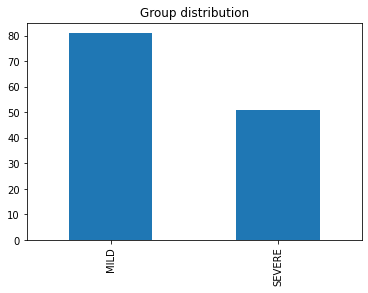

In [94]:
y.value_counts().plot(kind='bar', title='Group distribution');

In [95]:
smote = SMOTE(sampling_strategy ='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X[features], y)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_980\361123966.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = y_sm


<AxesSubplot:title={'center':'Count (target)'}>

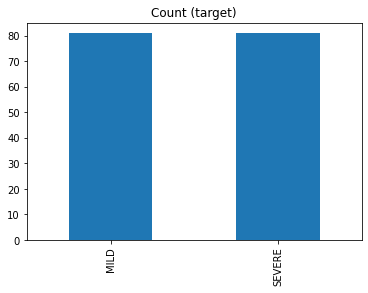

In [96]:
df = pd.DataFrame(X_sm, columns=features)
df['target'] = y_sm

df['target'].value_counts().plot(kind='bar', title='Count (target)')

#### testing the best approach for classification but now using the synthetic data

In [97]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=SEED, )

In [98]:
feat_selector.fit(np.array(X_sm), y_sm)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	148
Rejected: 	487
Iteration: 	9 / 100
Confirmed: 	35
Tentative: 	113
Rejected: 	487
Iteration: 	10 / 100
Confirmed: 	35
Tentative: 	113
Rejected: 	487
Iteration: 	11 / 100
Confirmed: 	35
Tentative: 	113
Rejected: 	487
Iteration: 	12 / 100
Confirmed: 	41
Tentative: 	95
Rejected: 	499
Iteration: 	13 / 100
Confirmed: 	41
Tentative: 	95
Rejected: 	499
Iteration: 	14 / 100
Confirmed: 	41
Tentative: 	95
Rejected: 	499
Iteration: 	15 / 100
Confirmed: 	41
Tentative: 	95
Rejected: 	499
Iteration: 	16 / 100
Confirmed

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=288, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2380411AF40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2380411AF40, verbose=2)

In [99]:
print("Number of selected features: ", feat_selector.n_features_)

Number of selected features:  63


In [100]:
# Best Features (accord to Boruta)
X_sm.columns[feat_selector.support_]

Index(['Freq.1261.01801005892', 'Freq.1324.08044804632',
       'Freq.1477.74871633496', 'Freq.1523.06577785676',
       'Freq.1571.40357692951', 'Freq.1715.32907573994',
       'Freq.1793.31292765446', 'Freq.1950.92667543594',
       'Freq.1972.54753680164', 'Freq.1984.28695988636',
       'Freq.1989.65991446642', 'Freq.2032.95119529926',
       'Freq.2079.98280714492', 'Freq.2148.55916353654',
       'Freq.2182.52259691583', 'Freq.2186.33577081196',
       'Freq.2208.11994786374', 'Freq.2242.07973381149',
       'Freq.2245.4309661224', 'Freq.2382.53291586635',
       'Freq.2481.36511832931', 'Freq.2552.58836883553',
       'Freq.2822.5691494885', 'Freq.2926.87413924864',
       'Freq.2980.79091047279', 'Freq.2993.12607948295',
       'Freq.3044.21704373186', 'Freq.3062.70477950654',
       'Freq.3077.77601350217', 'Freq.3151.06004403914',
       'Freq.3275.06824878848', 'Freq.3414.71158220371',
       'Freq.3425.70211639867', 'Freq.3610.10023694714',
       'Freq.3850.44578942163', '

In [101]:
# Filter most importante features
X_transform = feat_selector.transform(np.array(X_sm))

In [102]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X_transform, y_sm, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [103]:
study = optuna.create_study(direction="maximize")

[I 2022-07-20 02:03:14,835] A new study created in memory with name: no-name-b7ae543e-3b12-4e43-9404-1b4cc139f343


In [104]:
study.optimize(objective, n_trials=50)

[I 2022-07-20 02:03:15,501] Trial 0 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 2.625025036504331, 'lambda_l2': 0.037477588440828394, 'num_leaves': 73, 'feature_fraction': 0.6957433696459281, 'bagging_fraction': 0.5529269438567083, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 757}. Best is trial 0 with value: 0.5.
[I 2022-07-20 02:03:15,790] Trial 1 finished with value: 0.5 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.6539487267603408e-05, 'lambda_l2': 7.343223446899036e-05, 'num_leaves': 144, 'feature_fraction': 0.5094513809163325, 'bagging_fraction': 0.49101833466608674, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 384}. Best is trial 0 with value: 0.5.
[I 2022-07-20 02:03:17,666] Trial 2 finished with value: 0.8973421834163353 and parameters: {'scalers': 'robust', 'lambda_l1': 2.7724602408201123e-08, 'lambda_l2': 7.127187716714074e-08, 'num_leaves': 214, 'feature_fraction': 0.6768117724390659, 'bagging_fraction': 0.7917

[I 2022-07-20 02:03:44,504] Trial 21 finished with value: 0.9153538904765687 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.5820312250231028e-07, 'lambda_l2': 0.0007584159283696458, 'num_leaves': 76, 'feature_fraction': 0.7870220206403912, 'bagging_fraction': 0.8312462148815994, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 668}. Best is trial 19 with value: 0.9161110523108604.
[I 2022-07-20 02:03:46,589] Trial 22 finished with value: 0.9117193096590221 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.3318815606533528e-07, 'lambda_l2': 0.0012684447508025506, 'num_leaves': 77, 'feature_fraction': 0.7728377330500426, 'bagging_fraction': 0.796004509827723, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 905}. Best is trial 19 with value: 0.9161110523108604.
[I 2022-07-20 02:03:48,020] Trial 23 finished with value: 0.9164978711948527 and parameters: {'scalers': 'minmax', 'lambda_l1': 3.3418844582178538e-06, 'lambda_l2': 0.0004735084604355869, 'num_leaves': 44,

[I 2022-07-20 02:04:14,388] Trial 42 finished with value: 0.9122812558098936 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.00014343110790534676, 'lambda_l2': 0.0061365252515844775, 'num_leaves': 55, 'feature_fraction': 0.9862862518999178, 'bagging_fraction': 0.6913096886173619, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 682}. Best is trial 36 with value: 0.9168910894606731.
[I 2022-07-20 02:04:16,324] Trial 43 finished with value: 0.9139703874416739 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.924565515129665e-05, 'lambda_l2': 0.0026032764539717155, 'num_leaves': 101, 'feature_fraction': 0.9192179218849311, 'bagging_fraction': 0.7685840320744166, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 806}. Best is trial 36 with value: 0.9168910894606731.
[I 2022-07-20 02:04:17,441] Trial 44 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 1.2266102553812062e-06, 'lambda_l2': 0.021305847907630685, 'num_leaves': 20, 'feature_fract

In [105]:
# Get best trial based on metric score
trial = study.best_trial

In [106]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: minmax
    lambda_l1: 0.000448721518046587
    lambda_l2: 0.08950832971776969
    num_leaves: 81
    feature_fraction: 0.850086231614933
    bagging_fraction: 0.5240589441343348
    bagging_freq: 6
    min_child_samples: 23
    max_depth: 749


In [107]:
# Best Score from HP Opt
trial.values[0]

0.9170964051932722

Possivel overfit causado pelo SMOTE

* testando outro tipo de SMOTE (KNN smote)

In [108]:
smoteKnn = KMeansSMOTE(sampling_strategy ='minority', n_jobs=-1)
X_sm_knn, y_sm_knn = smoteKnn.fit_resample(X[features], y)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_980\2222850431.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = y_sm_knn


<AxesSubplot:title={'center':'Count (target)'}>

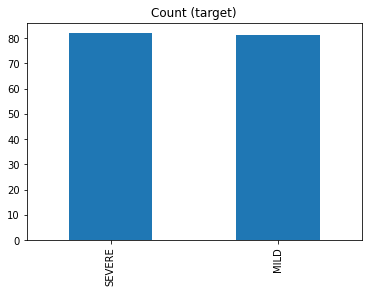

In [109]:
df = pd.DataFrame(X_sm_knn, columns=features)
df['target'] = y_sm_knn

df['target'].value_counts().plot(kind='bar', title='Count (target)')

In [110]:
feat_selector.fit(np.array(X_sm_knn), y_sm_knn)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	156
Rejected: 	479
Iteration: 	9 / 100
Confirmed: 	40
Tentative: 	116
Rejected: 	479
Iteration: 	10 / 100
Confirmed: 	40
Tentative: 	116
Rejected: 	479
Iteration: 	11 / 100
Confirmed: 	40
Tentative: 	116
Rejected: 	479
Iteration: 	12 / 100
Confirmed: 	45
Tentative: 	99
Rejected: 	491
Iteration: 	13 / 100
Confirmed: 	45
Tentative: 	99
Rejected: 	491
Iteration: 	14 / 100
Confirmed: 	45
Tentative: 	99
Rejected: 	491
Iteration: 	15 / 100
Confirmed: 	45
Tentative: 	99
Rejected: 	491
Iteration: 	16 / 100
Confirmed

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=266, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2380411AF40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2380411AF40, verbose=2)

In [111]:
print("Number of selected features: ", feat_selector.n_features_)

Number of selected features:  57


In [112]:
# Best Features (accord to Boruta)
X_sm_knn.columns[feat_selector.support_]

Index(['Freq.1223.24180676615', 'Freq.1715.32907573994',
       'Freq.1740.18797557113', 'Freq.1793.31292765446',
       'Freq.1874.22470784316', 'Freq.1915.56667060927',
       'Freq.1989.65991446642', 'Freq.2032.95119529926',
       'Freq.2148.55916353654', 'Freq.2182.52259691583',
       'Freq.2186.33577081196', 'Freq.2242.07973381149',
       'Freq.2245.4309661224', 'Freq.2822.5691494885', 'Freq.2926.87413924864',
       'Freq.3044.21704373186', 'Freq.3077.77601350217',
       'Freq.3194.41107599375', 'Freq.3275.06824878848',
       'Freq.3425.70211639867', 'Freq.3610.10023694714',
       'Freq.3722.2629296908', 'Freq.3912.82100942603',
       'Freq.4104.40173898671', 'Freq.4144.89285781313',
       'Freq.4244.80305549587', 'Freq.4266.3135397872',
       'Freq.4282.69712175929', 'Freq.4305.85988898402',
       'Freq.4318.14922038936', 'Freq.4374.21684152638',
       'Freq.4387.66582672803', 'Freq.4395.12541812139',
       'Freq.4411.07592736101', 'Freq.4434.44782516597',
       'Fr

In [113]:
# Filter most importante features
X_transform_knn = feat_selector.transform(np.array(X_sm_knn))

In [115]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X_transform_knn, y_sm_knn, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [116]:
study = optuna.create_study(direction="maximize")

[I 2022-07-20 02:07:01,054] A new study created in memory with name: no-name-69c8aa8c-d401-4784-afa9-ee35286692a8


In [117]:
study.optimize(objective, n_trials=50)

[I 2022-07-20 02:07:02,387] Trial 0 finished with value: 0.9029742828765663 and parameters: {'scalers': 'robust', 'lambda_l1': 7.854152592862897e-05, 'lambda_l2': 2.416231980309596e-07, 'num_leaves': 166, 'feature_fraction': 0.8324943617250078, 'bagging_fraction': 0.8306480442122652, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 331}. Best is trial 0 with value: 0.9029742828765663.
[I 2022-07-20 02:07:03,875] Trial 1 finished with value: 0.8801514742996942 and parameters: {'scalers': 'standard', 'lambda_l1': 0.006826671681737397, 'lambda_l2': 0.003267380220447326, 'num_leaves': 90, 'feature_fraction': 0.9538123428096177, 'bagging_fraction': 0.9901799824322135, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 476}. Best is trial 0 with value: 0.9029742828765663.
[I 2022-07-20 02:07:04,491] Trial 2 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0012580376082296264, 'lambda_l2': 0.017076764797910187, 'num_leaves': 52, 'feature_fraction': 0

[I 2022-07-20 02:07:30,582] Trial 21 finished with value: 0.9088117475919334 and parameters: {'scalers': 'robust', 'lambda_l1': 3.843877097128014e-07, 'lambda_l2': 7.252684852409211e-08, 'num_leaves': 146, 'feature_fraction': 0.6298562307307098, 'bagging_fraction': 0.6580261770558589, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 781}. Best is trial 20 with value: 0.9098459702921778.
[I 2022-07-20 02:07:32,426] Trial 22 finished with value: 0.9118892934980396 and parameters: {'scalers': 'robust', 'lambda_l1': 1.370128935087444e-07, 'lambda_l2': 1.6843058713477336e-07, 'num_leaves': 149, 'feature_fraction': 0.6337157813949136, 'bagging_fraction': 0.6304739890493619, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 778}. Best is trial 22 with value: 0.9118892934980396.
[I 2022-07-20 02:07:33,495] Trial 23 finished with value: 0.8209167141767761 and parameters: {'scalers': 'robust', 'lambda_l1': 9.589155497702425e-08, 'lambda_l2': 8.781194069672654e-07, 'num_leaves': 18

[I 2022-07-20 02:08:03,522] Trial 42 finished with value: 0.9051633965449755 and parameters: {'scalers': 'robust', 'lambda_l1': 0.00022279387749269094, 'lambda_l2': 1.4050877271404308e-07, 'num_leaves': 127, 'feature_fraction': 0.9171355532768535, 'bagging_fraction': 0.7942053773870015, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 485}. Best is trial 41 with value: 0.9122427749623958.
[I 2022-07-20 02:08:05,107] Trial 43 finished with value: 0.9017170466272634 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0027685034990614413, 'lambda_l2': 3.727994002554489e-08, 'num_leaves': 165, 'feature_fraction': 0.6896402978867615, 'bagging_fraction': 0.7572908658952044, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 586}. Best is trial 41 with value: 0.9122427749623958.
[I 2022-07-20 02:08:07,379] Trial 44 finished with value: 0.8929209660093947 and parameters: {'scalers': 'robust', 'lambda_l1': 2.4698749151145154e-07, 'lambda_l2': 2.7471419916691907e-08, 'num_leaves':

In [118]:
# Get best trial based on metric score
trial = study.best_trial

In [119]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: robust
    lambda_l1: 9.349971599326824e-05
    lambda_l2: 2.4952160884616552e-08
    num_leaves: 116
    feature_fraction: 0.796202935787731
    bagging_fraction: 0.7277596298678937
    bagging_freq: 1
    min_child_samples: 26
    max_depth: 582


In [120]:
# Best Score from HP Opt
trial.values[0]

0.9122427749623958

#### Teste com Adaptive Synthetic (ADASYN) algorithm SMOTE

In [121]:
smoteADA = ADASYN(sampling_strategy ='minority', n_jobs=-1)
X_sm_ADA, y_sm_ADA = smoteADA.fit_resample(X[features], y)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_980\2564322491.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = y_sm_ADA


<AxesSubplot:title={'center':'Count (target)'}>

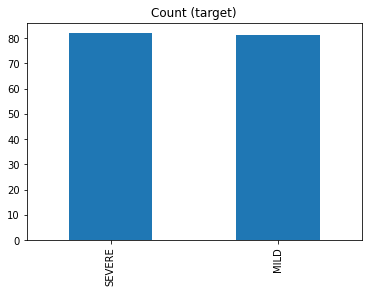

In [122]:
df = pd.DataFrame(X_sm_ADA, columns=features)
df['target'] = y_sm_ADA

df['target'].value_counts().plot(kind='bar', title='Count (target)')

In [123]:
feat_selector.fit(np.array(X_sm_ADA), y_sm_ADA)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	635
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	147
Rejected: 	488
Iteration: 	9 / 100
Confirmed: 	48
Tentative: 	99
Rejected: 	488
Iteration: 	10 / 100
Confirmed: 	48
Tentative: 	99
Rejected: 	488
Iteration: 	11 / 100
Confirmed: 	48
Tentative: 	99
Rejected: 	488
Iteration: 	12 / 100
Confirmed: 	52
Tentative: 	95
Rejected: 	488
Iteration: 	13 / 100
Confirmed: 	52
Tentative: 	87
Rejected: 	496
Iteration: 	14 / 100
Confirmed: 	52
Tentative: 	87
Rejected: 	496
Iteration: 	15 / 100
Confirmed: 	52
Tentative: 	87
Rejected: 	496
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=288, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2380411AF40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2380411AF40, verbose=2)

In [124]:
print("Number of selected features: ", feat_selector.n_features_)

Number of selected features:  71


In [125]:
# Best Features (accord to Boruta)
X_sm_ADA.columns[feat_selector.support_]

Index(['Freq.1261.01801005892', 'Freq.1324.08044804632',
       'Freq.1477.74871633496', 'Freq.1523.06577785676',
       'Freq.1571.40357692951', 'Freq.1647.83676716786',
       'Freq.1715.32907573994', 'Freq.1793.31292765446',
       'Freq.1950.92667543594', 'Freq.1972.54753680164',
       'Freq.1989.65991446642', 'Freq.2032.95119529926',
       'Freq.2051.88539120953', 'Freq.2079.98280714492',
       'Freq.2148.55916353654', 'Freq.2182.52259691583',
       'Freq.2186.33577081196', 'Freq.2208.11994786374',
       'Freq.2224.49761975722', 'Freq.2242.07973381149',
       'Freq.2245.4309661224', 'Freq.2382.53291586635',
       'Freq.2481.36511832931', 'Freq.2552.58836883553',
       'Freq.2761.81291676166', 'Freq.2822.5691494885',
       'Freq.2926.87413924864', 'Freq.2980.79091047279',
       'Freq.3044.21704373186', 'Freq.3077.77601350217',
       'Freq.3275.06824878848', 'Freq.3414.71158220371',
       'Freq.3425.70211639867', 'Freq.3520.59647058314',
       'Freq.3610.10023694714', '

In [126]:
# Filter most importante features
X_transform_ADA = feat_selector.transform(np.array(X_sm_ADA))

In [127]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X_transform_ADA, y_sm_ADA, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [129]:
study = optuna.create_study(direction="maximize")

[I 2022-07-20 02:10:52,490] A new study created in memory with name: no-name-569ae704-8725-4451-9a19-eb90499b10c9


In [130]:
study.optimize(objective, n_trials=50)

[I 2022-07-20 02:10:53,493] Trial 0 finished with value: 0.5674740500727343 and parameters: {'scalers': 'standard', 'lambda_l1': 7.821650766069514e-08, 'lambda_l2': 1.0931755868802867e-07, 'num_leaves': 184, 'feature_fraction': 0.8106964183209158, 'bagging_fraction': 0.53810044395208, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 964}. Best is trial 0 with value: 0.5674740500727343.
[I 2022-07-20 02:10:55,868] Trial 1 finished with value: 0.9266887884861955 and parameters: {'scalers': 'standard', 'lambda_l1': 0.00018221948443719445, 'lambda_l2': 0.05008006138796867, 'num_leaves': 249, 'feature_fraction': 0.5647045000328383, 'bagging_fraction': 0.48361002758314287, 'bagging_freq': 7, 'min_child_samples': 15, 'max_depth': 629}. Best is trial 1 with value: 0.9266887884861955.
[I 2022-07-20 02:10:56,832] Trial 2 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 0.002099167122268548, 'lambda_l2': 1.0076956214041772, 'num_leaves': 171, 'feature_fraction':

[I 2022-07-20 02:11:20,018] Trial 21 finished with value: 0.9093286493992763 and parameters: {'scalers': 'standard', 'lambda_l1': 0.20123583833463018, 'lambda_l2': 7.501757319324846e-05, 'num_leaves': 143, 'feature_fraction': 0.711379721615431, 'bagging_fraction': 0.5151235993676241, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 537}. Best is trial 14 with value: 0.9297224540810067.
[I 2022-07-20 02:11:21,659] Trial 22 finished with value: 0.9233719423851002 and parameters: {'scalers': 'standard', 'lambda_l1': 0.01236071136399938, 'lambda_l2': 3.7950440734652305e-06, 'num_leaves': 81, 'feature_fraction': 0.8123314911780154, 'bagging_fraction': 0.5896987190817036, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 509}. Best is trial 14 with value: 0.9297224540810067.
[I 2022-07-20 02:11:23,450] Trial 23 finished with value: 0.9191304429789336 and parameters: {'scalers': 'standard', 'lambda_l1': 0.03630221425639977, 'lambda_l2': 0.0017653139270226927, 'num_leaves': 120, 

[I 2022-07-20 02:11:54,749] Trial 41 finished with value: 0.923064718348387 and parameters: {'scalers': 'robust', 'lambda_l1': 4.945841651226771e-05, 'lambda_l2': 0.007201052580671323, 'num_leaves': 5, 'feature_fraction': 0.7251203509799251, 'bagging_fraction': 0.709805965457603, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 478}. Best is trial 14 with value: 0.9297224540810067.
[I 2022-07-20 02:11:58,481] Trial 42 finished with value: 0.9187709115574827 and parameters: {'scalers': 'robust', 'lambda_l1': 0.00046279169418629286, 'lambda_l2': 0.042292093879881636, 'num_leaves': 22, 'feature_fraction': 0.8625956698618079, 'bagging_fraction': 0.6689086851808821, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 543}. Best is trial 14 with value: 0.9297224540810067.
[I 2022-07-20 02:12:00,996] Trial 43 finished with value: 0.9198369569242247 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0038406481911285617, 'lambda_l2': 0.3171337522107936, 'num_leaves': 131, 'featur

In [131]:
# Get best trial based on metric score
trial = study.best_trial

In [132]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: standard
    lambda_l1: 2.7715867690487095e-06
    lambda_l2: 0.00010232046338310657
    num_leaves: 88
    feature_fraction: 0.5176445970778948
    bagging_fraction: 0.5603531435051413
    bagging_freq: 5
    min_child_samples: 16
    max_depth: 495


In [133]:
# Best Score from HP Opt
trial.values[0]

0.9297224540810067

* Dentre os SMOTES, ADA obteve o melhor score